In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds

In [2]:
ratings_df = pd.read_csv('ml-100k/u.data', sep='\t', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'])

# Count the number of ratings for each movie
movie_counts = ratings_df['item_id'].value_counts()

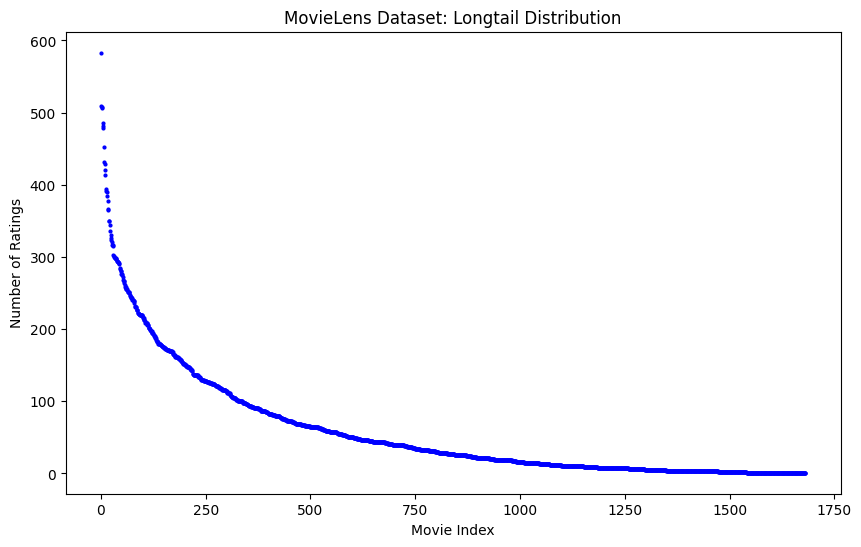

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(movie_counts.values, 'bo', markersize=2)
plt.xlabel('Movie Index')
plt.ylabel('Number of Ratings')
plt.title('MovieLens Dataset: Longtail Distribution')
# plt.yscale('sqrt')
plt.show()

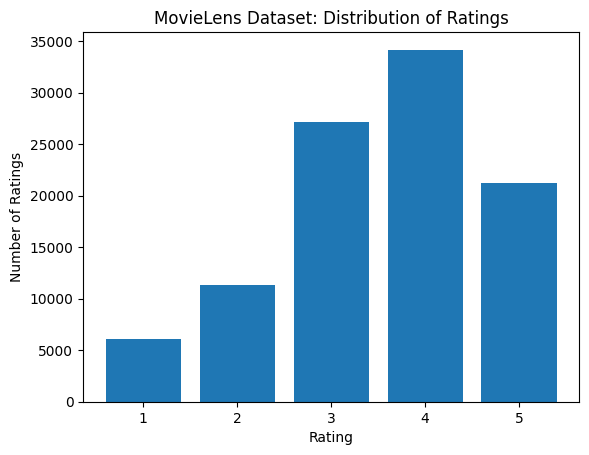

In [4]:
# Compute the distribution of ratings
rating_counts = ratings_df['rating'].value_counts().sort_index()
# Plot the distribution of ratings
plt.bar(rating_counts.index, rating_counts.values)
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.title('MovieLens Dataset: Distribution of Ratings')
plt.show()

In [5]:
users_df = pd.read_csv('./ml-100k/u.user', sep='|', header=None, names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

# Print the first few rows of the users DataFrame
print(users_df.head())

# Compute the distribution of genders in the users DataFrame
gender_counts = users_df['gender'].value_counts(normalize=True)

# Print the distribution of genders
print('Gender Distribution:')
print(gender_counts)

# Compute the distribution of ages in the users DataFrame
age_counts = users_df['age'].value_counts(normalize=True)

# Print the distribution of ages
print('Age Distribution:')
print(age_counts)

   user_id  age gender  occupation zip_code
0        1   24      M  technician    85711
1        2   53      F       other    94043
2        3   23      M      writer    32067
3        4   24      M  technician    43537
4        5   33      F       other    15213
Gender Distribution:
M    0.710498
F    0.289502
Name: gender, dtype: float64
Age Distribution:
30    0.041357
25    0.040297
22    0.039236
28    0.038176
27    0.037116
        ...   
7     0.001060
66    0.001060
11    0.001060
10    0.001060
73    0.001060
Name: age, Length: 61, dtype: float64


In [6]:
from surprise import Dataset
from surprise import Reader

# Load the MovieLens data
data_file = "ml-100k/u.data"
header = ["user_id", "item_id", "rating", "timestamp"]
df = pd.read_csv(data_file, sep="\t", names=header)

# Load item data
item_file = "ml-100k/u.item"
item_header = ["item_id", "title", "release_date", "video_release_date", "IMDb_URL"] + ["genre_{}".format(i) for i in range(1, 20)]
item_df = pd.read_csv(item_file, sep="|", names=item_header, encoding="latin-1")

# Preprocessing
df["rating"] = df["rating"].astype(float)
item_df["item_id"] = item_df["item_id"].astype(int)

# Define a function to identify long-tail items
def long_tail_items(df, threshold=0.2):
    item_counts = df["item_id"].value_counts()
    total_items = len(item_counts)
    tail_size = int(total_items * threshold)
    tail_items = item_counts.nsmallest(tail_size).index.tolist()
    return tail_items

# Identify long-tail items
tail_items = long_tail_items(df)

# Load data into Surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[["user_id", "item_id", "rating"]], reader)

In [7]:
from collections import defaultdict
import random
from surprise import SVD, KNNBasic
from surprise.model_selection import cross_validate, KFold

# Calculate precision and recall
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

# Apply SVD
algo = SVD()

# Cross validation
cv_results = cross_validate(algo, data, measures=["RMSE", "MAE"], cv=5, verbose=True)

# Calculate precision and recall using KFold
kf = KFold(n_splits=5)
precisions = []
recalls = []

for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    prec, rec = precision_recall_at_k(predictions, k=10, threshold=3.5)
    precisions.append(sum(prec.values()) / len(prec))
    recalls.append(sum(rec.values()) / len(rec))

# Print results
print(f"RMSE: {np.mean(cv_results['test_rmse']):.4f}")
print(f"MAE: {np.mean(cv_results['test_mae']):.4f}")
print(f"Precision: {np.mean(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f}")


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9326  0.9363  0.9406  0.9411  0.9333  0.9368  0.0036  
MAE (testset)     0.7364  0.7384  0.7432  0.7413  0.7355  0.7390  0.0029  
Fit time          0.68    0.66    0.70    0.47    0.45    0.59    0.11    
Test time         0.04    0.16    0.07    0.04    0.08    0.08    0.04    
RMSE: 0.9368
MAE: 0.7390
Precision: 0.7607
Recall: 0.5638


In [18]:
from surprise import accuracy
from surprise.prediction_algorithms.matrix_factorization import SVDpp
from surprise.prediction_algorithms.algo_base import AlgoBase
from surprise.model_selection import train_test_split
import math

# Custom scoring function
def score_function(est, iid, long_tail_boost=1.2):
    if iid in tail_items:
        return est * long_tail_boost
    else:
        return est

# Custom SVD algorithm
# class CustomSVD(AlgoBase):
#     def __init__(self, *args, **kwargs):
#         super().__init__()
#         self.svd = SVDpp(*args, **kwargs)
#
#     def fit(self, trainset):
#         self.trainset = trainset
#         self.svd.fit(trainset)
#         return self
#
#     def estimate(self, u, i):
#         est = self.svd.estimate(u, i)
#         return score_function(est, i)
# class CustomSVD(AlgoBase):
#     def __init__(self, alpha=0.2, *args, **kwargs):
#         super().__init__()
#         self.svd = SVDpp(*args, **kwargs)
#         self.alpha = alpha
#
#     def fit(self, trainset):
#         self.trainset = trainset
#         self.svd.fit(trainset)
#         return self
#
#     def estimate(self, u, i):
#         est = self.svd.estimate(u, i)
#         try:
#             inner_iid = self.trainset.to_inner_iid(i)
#             item_frequency = self.trainset.ir[inner_iid]
#             item_popularity = len(item_frequency) / self.trainset.n_ratings
#             adjustment = self.alpha * item_popularity
#             return est * (1 - adjustment)
#         except ValueError:
#             return est
# class CustomSVD(AlgoBase):
#     def __init__(self, alpha=0.05, beta=5, *args, **kwargs):
#         super().__init__()
#         self.svd = SVDpp(*args, **kwargs)
#         self.alpha = alpha
#         self.beta = beta
#
#     def fit(self, trainset):
#         self.trainset = trainset
#         self.svd.fit(trainset)
#         return self
#
#     def estimate(self, u, i):
#         est = self.svd.estimate(u, i)
#         try:
#             inner_iid = self.trainset.to_inner_iid(i)
#             item_frequency = self.trainset.ir[inner_iid]
#             item_popularity = len(item_frequency) / self.trainset.n_ratings
#             adjustment = self.alpha * item_popularity
#             calibrated_est = est * (1 - adjustment)
#
#             # Apply calibration using a sigmoid function
#             calibrated_est = 1 / (1 + math.exp(-self.beta * (calibrated_est - 0.5)))
#             return calibrated_est
#         except ValueError:
#             return est
class CustomSVD(AlgoBase):
    def __init__(self, alpha=0.2, beta=5, *args, **kwargs):
        super().__init__()
        self.svd = SVDpp(*args, **kwargs)
        self.alpha = alpha
        self.beta = beta

    def fit(self, trainset):
        self.trainset = trainset
        self.svd.fit(trainset)
        self.avg_rating = trainset.global_mean  # calculate the average rating
        return self

    def estimate(self, u, i):
        est = self.svd.estimate(u, i)
        try:
            inner_iid = self.trainset.to_inner_iid(i)
            item_frequency = self.trainset.ir[inner_iid]
            item_popularity = len(item_frequency) / self.trainset.n_ratings
            adjustment = self.alpha * item_popularity
            calibrated_est = est * (1 - adjustment)

            # Apply calibration using a sigmoid function
            # calibrated_est = 1 / (1 + math.exp(-self.beta * (calibrated_est - self.avg_rating)))
            calibrated_est = est * math.exp(-self.beta * adjustment)
            return calibrated_est
        except ValueError:
            return est

# Instantiate and fit the custom SVD algorithm
algo = CustomSVD(n_factors=50, lr_all=0.005, reg_all=0.02)
trainset, testset = train_test_split(data, test_size=0.2)
algo.fit(trainset)

# Test the custom SVD algorithm
predictions_custom_svd = algo.test(testset)

# Evaluate the custom SVD algorithm
rmse = accuracy.rmse(predictions_custom_svd)
mae = accuracy.mae(predictions_custom_svd)
precisions, recalls = precision_recall_at_k(predictions_custom_svd, k=10, threshold=3.5)
# precision = sum(precisions.values()) / len(predictions_custom_svd)
# recall = sum(recalls.values()) / len(recalls)
precision = sum(prec for prec in precisions.values()) / len(precisions)
recall = sum(rec for rec in recalls.values()) / len(recalls)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


RMSE: 0.9244
MAE:  0.7272
RMSE: 0.9244
MAE: 0.7272
Precision: 0.7705
Recall: 0.5717


In [9]:
algo = CustomSVD(alpha=0.05, beta=5)

# Perform 5-fold cross-validation
cv_results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Calculate the average RMSE and MAE from cross-validation
mean_rmse = cv_results['test_rmse'].mean()
mean_mae = cv_results['test_mae'].mean()

print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Mean MAE: {mean_mae:.4f}")


Evaluating RMSE, MAE of algorithm CustomSVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9282  0.9121  0.9136  0.9220  0.9220  0.9196  0.0059  
MAE (testset)     0.7268  0.7179  0.7186  0.7205  0.7237  0.7215  0.0033  
Fit time          6.36    6.26    6.36    6.36    6.89    6.45    0.23    
Test time         1.42    1.60    1.46    1.52    1.44    1.49    0.07    
Mean RMSE: 0.9196
Mean MAE: 0.7215


In [19]:
baseline_algo_svd = SVD()
baseline_algo_knn = KNNBasic()
proposed_algo = CustomSVD(alpha=0.05, beta=5)

trainset, testset = train_test_split(data, test_size=0.2)

# Train algorithms on the trainset
baseline_algo_svd.fit(trainset)
baseline_algo_knn.fit(trainset)
proposed_algo.fit(trainset)

# Generate predictions on the testset
predictions_svd = baseline_algo_svd.test(testset)
predictions_knn = baseline_algo_knn.test(testset)
predictions_custom_svd = proposed_algo.test(testset)
# Evaluate algorithms using cross-validation
cv_svd = cross_validate(baseline_algo_svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
cv_knn = cross_validate(baseline_algo_knn, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
cv_custom_svd = cross_validate(proposed_algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
# baseline_algo_knn.fit(trainset)
# predictions_knn = baseline_algo_knn.test(testset)
# Print results
print("Baseline SVD Results:")
print(f"RMSE: {cv_svd['test_rmse'].mean():.4f}")
print(f"MAE: {cv_svd['test_mae'].mean():.4f}")

print("\nBaseline KNN Results:")
print(f"RMSE: {cv_knn['test_rmse'].mean():.4f}")
print(f"MAE: {cv_knn['test_mae'].mean():.4f}")

print("\nProposed Custom SVD Results:")
print(f"RMSE: {cv_custom_svd['test_rmse'].mean():.4f}")
print(f"MAE: {cv_custom_svd['test_mae'].mean():.4f}")

# Calculate Precision and Recall for each algorithm
precisions_svd, recalls_svd = precision_recall_at_k(predictions_svd, k=10, threshold=3.5)
precisions_knn, recalls_knn = precision_recall_at_k(predictions_knn, k=10, threshold=3.5)
precisions_custom_svd, recalls_custom_svd = precision_recall_at_k(predictions_custom_svd, k=10, threshold=3.5)

precision_svd = sum(precisions_svd.values()) / len(precisions_svd)
recall_svd = sum(recalls_svd.values()) / len(recalls_svd)

precision_knn = sum(precisions_knn.values()) / len(precisions_knn)
recall_knn = sum(recalls_knn.values()) / len(recalls_knn)

precision_custom_svd = sum(precisions_custom_svd.values()) / len(precisions_custom_svd)
recall_custom_svd = sum(recalls_custom_svd.values()) / len(recalls_custom_svd)

# Print Precision and Recall results
print("\nBaseline SVD Results:")
print(f"Precision: {precision_svd:.4f}")
print(f"Recall: {recall_svd:.4f}")

print("\nBaseline KNN Results:")
print(f"Precision: {precision_knn:.4f}")
print(f"Recall: {recall_knn:.4f}")

print("\nProposed Custom SVD Results:")
print(f"Precision: {precision_custom_svd:.4f}")
print(f"Recall: {recall_custom_svd:.4f}")

Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9396  0.9334  0.9347  0.9371  0.9362  0.9362  0.0021  
MAE (testset)     0.7369  0.7365  0.7374  0.7393  0.7393  0.7379  0.0012  
Fit time          0.53    0.61    0.58    0.54    0.64    0.58    0.04    
Test time         0.07    0.05    0.05    0.05    0.05    0.05    0.01    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     

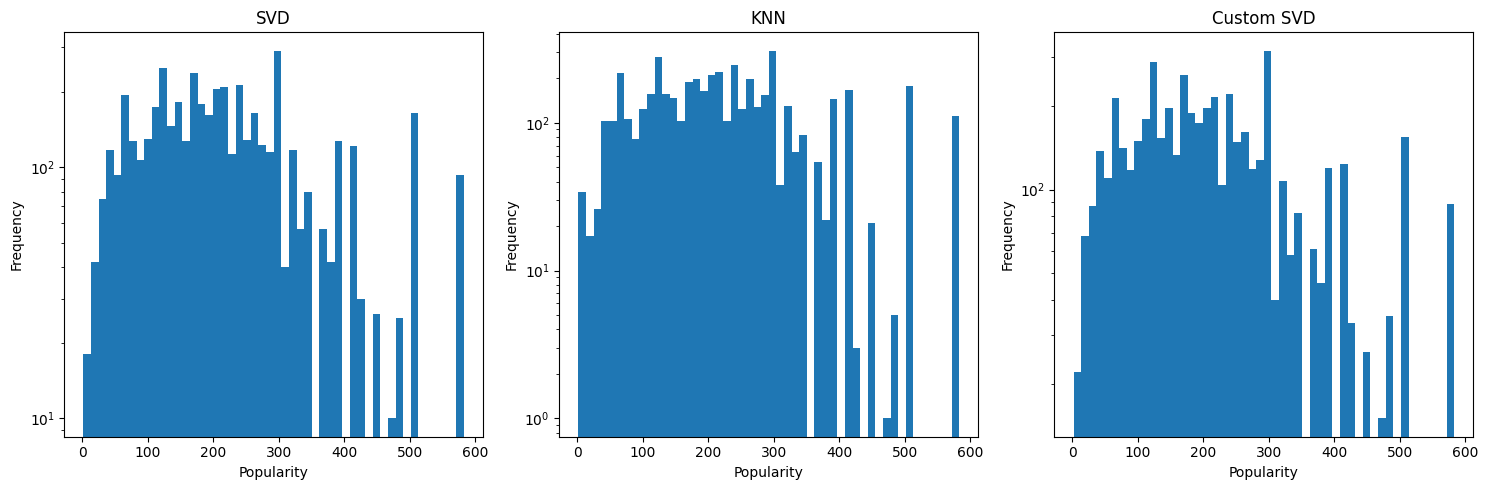

In [20]:
item_counts = {}
for _, row in df.iterrows():
    item_counts[row['item_id']] = item_counts.get(row['item_id'], 0) + 1

# Extract the recommended items
def get_recommendations(predictions):
    recommendations = []
    for pred in predictions:
        if pred.est >= 4:  # Recommended items with predicted rating >= 4
            recommendations.append(pred.iid)
    return recommendations

recommended_svd = get_recommendations(predictions_svd)
recommended_knn = get_recommendations(predictions_knn)
recommended_custom_svd = get_recommendations(predictions_custom_svd)

# Calculate the popularity of recommended items
def get_popularity(recommended_items):
    popularity = []
    for item in recommended_items:
        popularity.append(item_counts[item])
    return popularity

popularity_svd = get_popularity(recommended_svd)
popularity_knn = get_popularity(recommended_knn)
popularity_custom_svd = get_popularity(recommended_custom_svd)

# Visualize the distribution of popular and less popular items
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(popularity_svd, bins=50, log=True)
plt.title("SVD")
plt.xlabel("Popularity")
plt.ylabel("Frequency")

plt.subplot(1, 3, 2)
plt.hist(popularity_knn, bins=50, log=True)
plt.title("KNN")
plt.xlabel("Popularity")
plt.ylabel("Frequency")

plt.subplot(1, 3, 3)
plt.hist(popularity_custom_svd, bins=50, log=True)
plt.title("Custom SVD")
plt.xlabel("Popularity")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()